In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
data = open("datartl_00000101.bin", "rb").read()
(serial_no, cfreq, srate, tv_sec, tv_nsec, bufsize) = struct.unpack("@IIIIII", data[:24])
fulltime1 = tv_sec + (tv_nsec/1e9)

print ("Device serial number was", serial_no)
print ("Timestamp was", fulltime1)
print ("Centre frequency was", cfreq)
print ("Sampling rate was", srate)
print ("Buffer size was", bufsize)

bindata1 = np.array(struct.unpack("B"*int(bufsize), data[24:])).astype(np.uint8)
bindata_complex1 = bindata1[0::2] + bindata1[1::2]*1j
bindata_complex1 = bindata_complex1-np.mean(bindata_complex1)

# struct.unpack("B"*int(bufsize), data[24:])[0:10]

Device serial number was 101
Timestamp was 1690701473.2474387
Centre frequency was 217800000
Sampling rate was 2400000
Buffer size was 8388608


In [3]:
data2 = open("datartl_00000102.bin", "rb").read()
(serial_no, cfreq, srate, tv_sec, tv_nsec, bufsize) = struct.unpack("@IIIIII", data2[:24])
fulltime2 = tv_sec + (tv_nsec/1e9)

print ("Device serial number was", serial_no)
print ("Timestamp was", fulltime2)
print ("Centre frequency was", cfreq)
print ("Sampling rate was", srate)
print ("Buffer size was", bufsize)

bindata2 = np.array(struct.unpack("B"*int(bufsize), data2[24:])).astype(np.uint8)
bindata_complex2 = bindata2[0::2] + bindata2[1::2]*1j
bindata_complex2 = bindata_complex2 - np.mean(bindata_complex2)

# struct.unpack("B"*int(bufsize), data2[24:])[0:10]

Device serial number was 102
Timestamp was 1690701473.2221298
Centre frequency was 217800000
Sampling rate was 2400000
Buffer size was 8388608


In [4]:
if fulltime1 < fulltime2:
    print ("SDR 1 started earlier, dropping its samples")
    tdiff = fulltime2 - fulltime1 
    Nsamps = int(tdiff*srate)
    print (Nsamps)
    datum_1 = bindata_complex1[Nsamps::]
    datum_2 = bindata_complex2[0:len(datum_1)]
else:
    print ("SDR 2 started earlier, dropping its samples")
    tdiff = fulltime1 - fulltime2 
    Nsamps = int(tdiff*srate)
    print (Nsamps)
    datum_2 = bindata_complex2[Nsamps::]
    datum_1 = bindata_complex1[0:len(datum_2)]


SDR 2 started earlier, dropping its samples
60741


In [15]:
NFFT = 8192

Naver = int(len(datum_1)/NFFT)

auto11_aligned  = np.zeros(NFFT, dtype=np.complex128) 
auto22_aligned  = np.zeros(NFFT, dtype=np.complex128) 
cross12_aligned = np.zeros(NFFT, dtype=np.complex128)

auto11_raw      = np.zeros(NFFT, dtype=np.complex128)
auto22_raw      = np.zeros(NFFT, dtype=np.complex128)
cross12_raw     = np.zeros(NFFT, dtype=np.complex128)

for i in range(Naver):
    dat_1_fft = np.fft.fftshift(np.fft.fft(datum_1[i*NFFT: (i+1)*NFFT]))
    dat_2_fft = np.fft.fftshift(np.fft.fft(datum_2[i*NFFT: (i+1)*NFFT]))
    auto11_aligned  = auto11_aligned + dat_1_fft*np.conj(dat_1_fft)
    auto22_aligned  = auto22_aligned + dat_2_fft*np.conj(dat_2_fft)
    cross12_aligned = cross12_aligned + dat_1_fft*np.conj(dat_2_fft)

for i in range(Naver):
    dat_1_fft = np.fft.fftshift(np.fft.fft(bindata_complex1[i*NFFT: (i+1)*NFFT]))
    dat_2_fft = np.fft.fftshift(np.fft.fft(bindata_complex2[i*NFFT: (i+1)*NFFT]))
    auto11_raw = auto11_raw + dat_1_fft*np.conj(dat_1_fft)
    auto22_raw = auto22_raw + dat_2_fft*np.conj(dat_2_fft)
    cross12_raw = cross12_raw + dat_1_fft*np.conj(dat_2_fft)


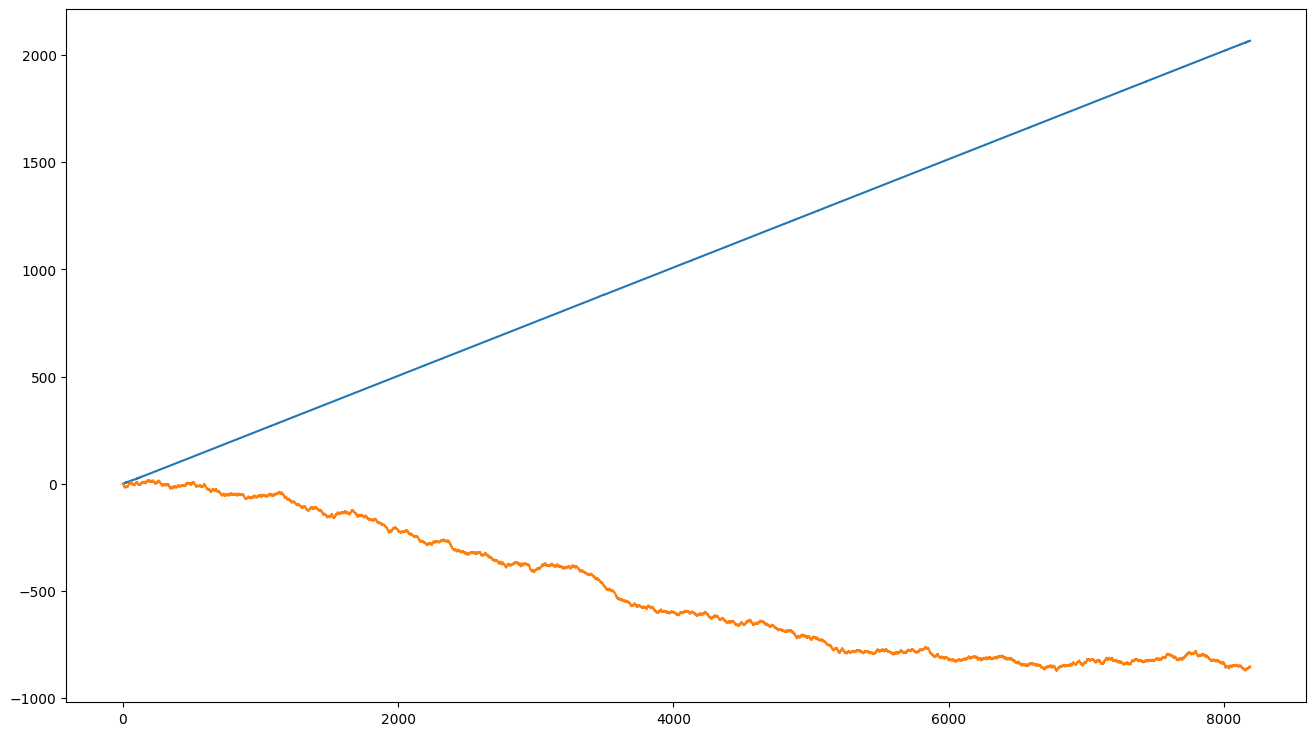

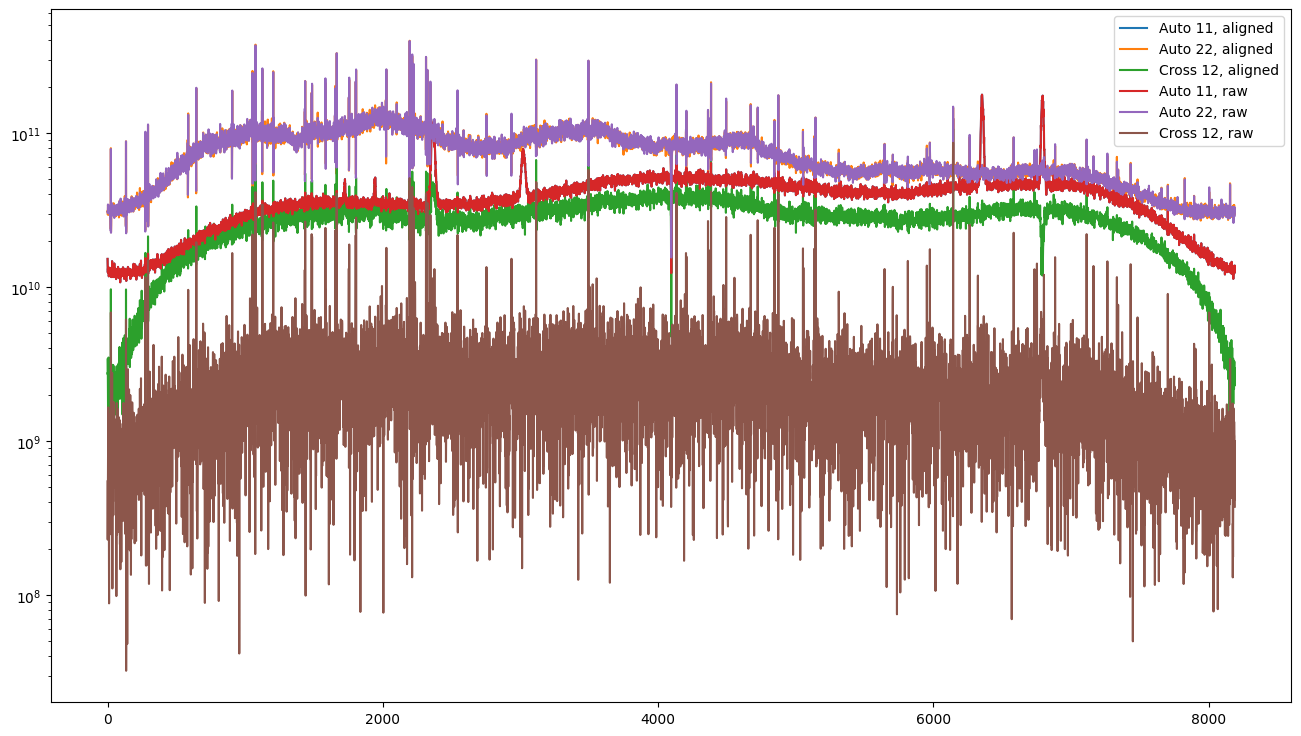

In [17]:
plt.figure(figsize=(16,9))
plt.plot(np.unwrap(np.angle(cross12_aligned)))
plt.plot(np.unwrap(np.angle(cross12_raw)))

# plt.figure(figsize=(16,9))
# plt.plot(np.angle(cross12_aligned)[0:100])
# plt.plot(np.angle(cross12_raw)[0:100])

plt.figure(figsize=(16,9))
plt.semilogy(np.abs(auto11_aligned), label="Auto 11, aligned")
plt.semilogy(np.abs(auto22_aligned), label="Auto 22, aligned")
plt.semilogy(np.abs(cross12_aligned), label="Cross 12, aligned")
plt.semilogy(np.abs(auto11_raw), label="Auto 11, raw")
plt.semilogy(np.abs(auto22_raw), label="Auto 22, raw")
plt.semilogy(np.abs(cross12_raw), label="Cross 12, raw")
plt.legend(loc='best')


In [7]:
# plt.figure(figsize=(16,9))
# plt.plot(np.real(datum_1[0:1000]))
# plt.plot(np.imag(datum_2[0:1000]))

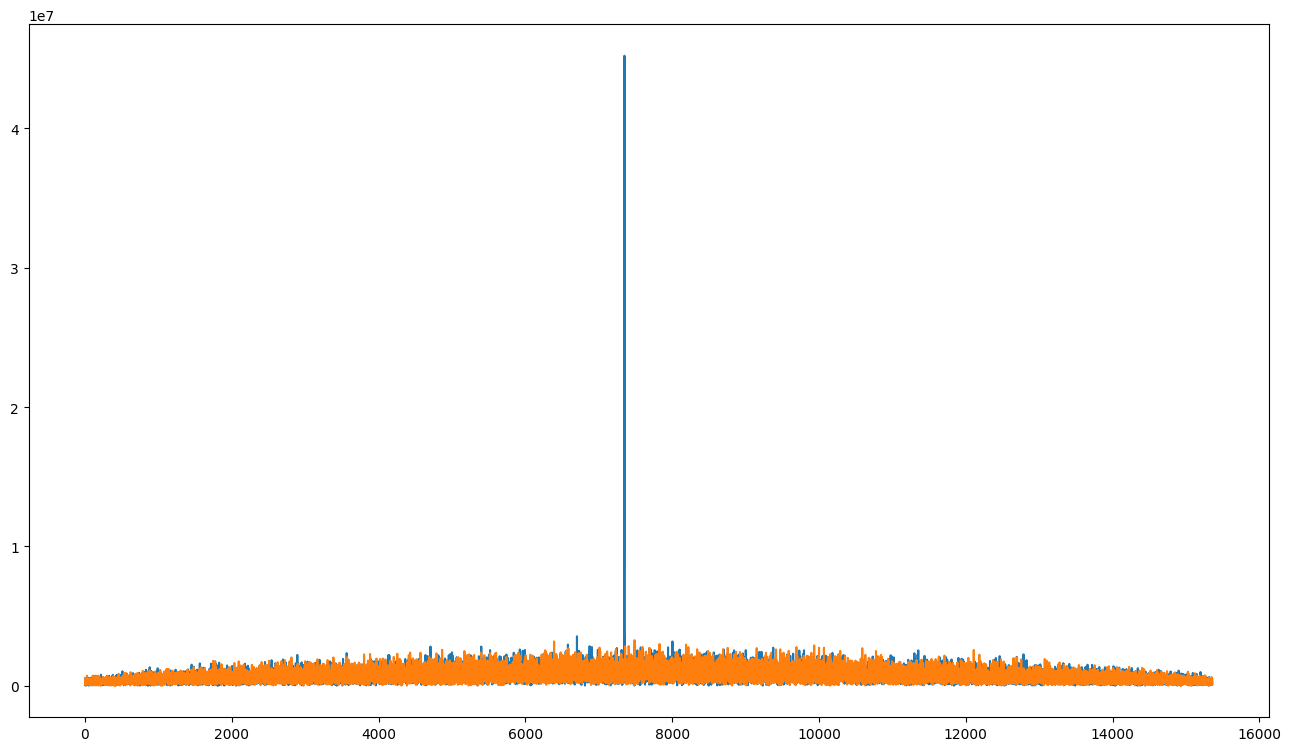

In [18]:
Ncorr = 8192

corrdat = np.correlate(datum_1[0:Ncorr], datum_2[0:Ncorr], mode='full')
corrraw = np.correlate(bindata_complex1[0:Ncorr], bindata_complex2[0:Ncorr], mode='full')
norm = np.correlate(np.ones(Ncorr), np.ones(Ncorr), mode='full')


frac_plot = int(1*Ncorr/16)
plt.figure(figsize=(16,9))
plt.plot((np.abs(corrdat))[frac_plot:-frac_plot])
plt.plot((np.abs(corrraw))[frac_plot:-frac_plot])